In [1]:
%matplotlib inline

# Getting started with sequence-based learning

This notebook will briefly cover how to run `assaydata`, `train`, `predict`, `design` workflows. 

For more information please [read the docs](https://docs.openprotein.ai/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns 
sns.set() 


## Setup

Connect to the OpenProtein backend with your credentials:

In [3]:
import openprotein

with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(username= config['username'], password= config['password']) 

We will use a small sample of the AMIE PSEAE dataset as a demo, the full data is available on our [website](https://docs.openprotein.ai/walkthroughs/demo-datasets-page.html):

In [4]:
dataset = pd.read_csv("./data/AMIE_PSEAE.csv")
dataset.head(2)

,sequence,isobutyramide_normalized_fitness,acetamide_normalized_fitness,propionamide_normalized_fitness
0,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,-0.5174,NaN,NaN
1,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,-0.5154,-2.1514,-1.1457


## Data Upload

Create the Demo data in the backend to be able to use it with our suite of tools:

In [5]:
# Create
assay = session.data.create(dataset, "Dataset Name", "Dataset description")
assay_id = assay.id
assay

AssayMetadata(assay_name='Dataset Name', assay_description='Dataset description', assay_id='476d6e9b-33ba-410d-aec2-5e3a20e33285', original_filename='assay_data', created_date=datetime.datetime(2024, 4, 9, 2, 4, 37, 973215), num_rows=15, num_entries=41, measurement_names=['isobutyramide_normalized_fitness', 'acetamide_normalized_fitness', 'propionamide_normalized_fitness'], sequence_length=346)

We could also have loaded a job from an old job ID. This will be faster and more efficient for users resuming workflows:

In [6]:
assay = session.data.load_assay(assay_id) # can reload job to resume workflows

In [7]:
assay.get_first()

,sequence,isobutyramide_normalized_fitness,acetamide_normalized_fitness,propionamide_normalized_fitness
0,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,-0.5174,None,None


In [8]:
assay.get_slice(start=3, end=5)

,sequence,isobutyramide_normalized_fitness,acetamide_normalized_fitness,propionamide_normalized_fitness
0,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKWAEMIVGMK...,NaN,NaN,-0.7550
1,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKYAEMIVGMK...,-0.7448,-1.7992,-0.9711


In [9]:
assay.sequence_length

346

## Model training

We can use the assay object to create a training job:

In [10]:
train = session.train.create_training_job(assay,
                                          measurement_name=["acetamide_normalized_fitness"],
                                          model_name="mymodel") # name the resulting model
train_id = train.id
train

Job(status=<JobStatus.PENDING: 'PENDING'>, job_id='150860c1-d8b0-4804-8914-28409bbcc0fe', job_type='/workflow/train', created_date=datetime.datetime(2024, 4, 9, 2, 4, 38, 309629), start_date=None, end_date=None, prerequisite_job_id='ccad1469-5843-414c-90cd-2f93149df1f3', progress_message=None, progress_counter=None, num_records=None, sequence_length=346)

In [11]:
train.refresh()
train.status

<JobStatus.PENDING: 'PENDING'>

We can wait for the results before proceeding:

In [12]:
results = train.wait(verbose=True)

Waiting: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, status=SUCCESS]


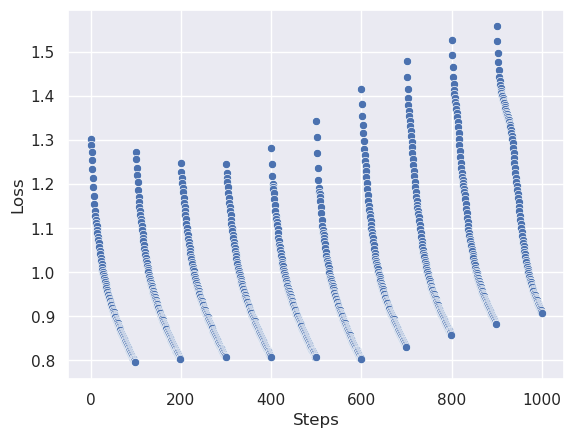

In [13]:

sns.scatterplot(x=range(len(results["acetamide_normalized_fitness"])), y=results["acetamide_normalized_fitness"] )
plt.xlabel("Steps")
plt.ylabel("Loss");

We can also request a cross-validation job to see the training results in more detail:

In [14]:
cvjob = train.crossvalidate()
cvjob.status

<JobStatus.PENDING: 'PENDING'>

In [15]:
cvdata = cvjob.wait(verbose=True)

Waiting: 100%|██████████| 100/100 [00:05<00:00, 19.87it/s, status=SUCCESS]


In [16]:
cvdata = pd.DataFrame(cvdata)
cvdata.head()

,row_index,sequence,measurement_name,y,y_mu,y_var
0,1,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,acetamide_normalized_fitness,-2.1514,-2.150992,0.000373
1,2,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,acetamide_normalized_fitness,-2.1514,-2.150993,0.000373
2,4,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKYAEMIVGMK...,acetamide_normalized_fitness,-1.7992,-0.757357,0.299005
3,5,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKPAEMIVGMK...,acetamide_normalized_fitness,-1.6838,-1.446090,0.407005
4,6,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKMAEMIVGMK...,acetamide_normalized_fitness,-0.1761,-0.607089,0.162582


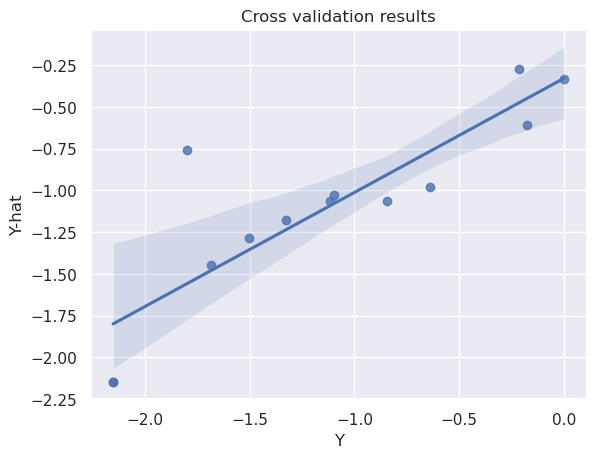

In [17]:

sns.regplot(x=cvdata.y.to_list() , y=cvdata.y_mu.to_list() )
plt.xlabel("Y")
plt.title("Cross validation results")
plt.ylabel("Y-hat");

We can examine the models associated with a train or assaydata set. These will be identical here but multiple train jobs are possible on a single assaydata:

## Sequence predictions

We can also predict scores for new sequences using our models trained on our old sequences:

In [18]:
import random 
def fakeseq(length=100, amino_acids="GAVLIMFWPSTCYNQDEKRH"):
    simulated_protein = ""
    for i in range(length):
        aa = random.choice(amino_acids)
        simulated_protein += aa 
    return simulated_protein

# Create some random sequences to predict
np.random.seed(111)
p_seqs = [fakeseq(assay.sequence_length) for i in range(3)]
p_seqs


['STATPFQPLPDQKEGQDIPRFLQETADNVHQMCYMMTLMDAAPSFMCETKHLANCSFYFCMMCMRHKMHVIGTGTYRMGADMHGYNDCQSGYKMFAGSMICALQNPTYVPRSLKWPYTVCVTWKKYVLGDMVVYFMFGLVEWQAWPGKRYHTYDIKQWYRDRGIGRWTCCDLEGCQKSPYYMPFETPMAFDMGHCCGATKHDETKSPDIGWYKHCCKDRLPWLCFLWMSVINMRMMTQAKVFQHMNLHYPYGAQIPLVRMAAWSFMIGGDRPCYMVYHDQMVCQAWQWLWFATDMRYQYYFPLEEHSIMKWYEFLRVSSFRACCRTFCRQKKAYNWIGEKVFWQSW',
 'WFTKHANIMHIMRADTYKIWARPEKSCIWDLHMSMCSACSWYYFSDALERAYIGHPLLGMPWGQHIADLSFKYKQVAIWIVTDNISGPRTGCIDAHENTSAKNPLIIKCQPIDGGCGSRCPFMLPGCFTMSFERNDLLCYNFRRVWPTQQWMNLKERASIRMWLPKRNDSQYKMEVHSNNMQMDPSDVLRHYTHSDWAKCPTCKIVKFDDFPFHDGNEPNRHQFHKMVKVRVTDAEEITGVRQWSPMHQEMVRNQGPRVCHQCQDQEAPMNQNPEHYFCTCGVIAPPDSRGCPSQMMFDGCPGRTHAYGGFQDAHGWHYQTRHHKWQYHISTWLHKQDADGDWWWA',
 'SLRACPERANHESNLANDVLHPKTQMHHIYHEYARVGKFHKTGGYLMMQKALLKQSRVYGWSMSQTSKACPYWKGTFKLSPEYSSMNNCHFDSGEMWFKLHKNFCGFLDRCFYCVQSEPKEKHITHGCCDQSNNWMKLWGRTWTHINWKRMEAVEMATFDNGEVPAMAIMSFPTLHCWSCCWWYVEEEYQTKKPQKASMNEWYSHPVDGAPGAQMWWLHIQNNFYIGASVGIWTHCCFAFSIDRHFMYWTQRWCHVIWHRLDETHYLTLNHSCVLQAFIEPCKWKPSFGTGHVQGT

In [19]:
pjob = train.predict(sequences=p_seqs)
pjob_id = pjob.id
pjob

PredictJob(status=<JobStatus.PENDING: 'PENDING'>, job_id='44658be8-90e4-4fda-9adf-250332de6754', job_type=<JobType.workflow_predict: '/workflow/predict'>, created_date=None, start_date=None, end_date=None, prerequisite_job_id=None, progress_message=None, progress_counter=0, num_records=None, sequence_length=None, result=None)

In [20]:
results = pjob.wait(verbose=True)

Waiting: 100%|██████████| 100/100 [00:21<00:00,  4.76it/s, status=SUCCESS]


In [21]:
results['acetamide_normalized_fitness']

{'STATPFQPLPDQKEGQDIPRFLQETADNVHQMCYMMTLMDAAPSFMCETKHLANCSFYFCMMCMRHKMHVIGTGTYRMGADMHGYNDCQSGYKMFAGSMICALQNPTYVPRSLKWPYTVCVTWKKYVLGDMVVYFMFGLVEWQAWPGKRYHTYDIKQWYRDRGIGRWTCCDLEGCQKSPYYMPFETPMAFDMGHCCGATKHDETKSPDIGWYKHCCKDRLPWLCFLWMSVINMRMMTQAKVFQHMNLHYPYGAQIPLVRMAAWSFMIGGDRPCYMVYHDQMVCQAWQWLWFATDMRYQYYFPLEEHSIMKWYEFLRVSSFRACCRTFCRQKKAYNWIGEKVFWQSW': {'mean': -1.4383549690246582,
  'variance': 0.40846166014671326},
 'WFTKHANIMHIMRADTYKIWARPEKSCIWDLHMSMCSACSWYYFSDALERAYIGHPLLGMPWGQHIADLSFKYKQVAIWIVTDNISGPRTGCIDAHENTSAKNPLIIKCQPIDGGCGSRCPFMLPGCFTMSFERNDLLCYNFRRVWPTQQWMNLKERASIRMWLPKRNDSQYKMEVHSNNMQMDPSDVLRHYTHSDWAKCPTCKIVKFDDFPFHDGNEPNRHQFHKMVKVRVTDAEEITGVRQWSPMHQEMVRNQGPRVCHQCQDQEAPMNQNPEHYFCTCGVIAPPDSRGCPSQMMFDGCPGRTHAYGGFQDAHGWHYQTRHHKWQYHISTWLHKQDADGDWWWA': {'mean': -1.4383549690246582,
  'variance': 0.40846166014671326},
 'SLRACPERANHESNLANDVLHPKTQMHHIYHEYARVGKFHKTGGYLMMQKALLKQSRVYGWSMSQTSKACPYWKGTFKLSPEYSSMNNCHFDSGEMWFKLHKNFCGFLDRCFYCVQSEPKEKHITHGCCDQSNNWMKLWGRTWTHINWKRMEAVEMATFDNGEV

We can also send a single sequence for single site mutation analysis:

In [22]:
sequence = assay.get_first().sequence[0]

sspredict = train.predict_single_site(sequence)


In [23]:
sspredict

PredictSingleSiteJob(status=<JobStatus.PENDING: 'PENDING'>, job_id='d02b1dcd-c54b-4618-8c75-0da93ac64d1a', job_type=<JobType.worflow_predict_single_site: '/workflow/predict/single_site'>, created_date=None, start_date=None, end_date=None, prerequisite_job_id=None, progress_message=None, progress_counter=0, num_records=None, sequence_length=None, result=None)

In [24]:
ssp_results = sspredict.wait(verbose=True)
ssp_results

Waiting: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it, status=SUCCESS]


{'acetamide_normalized_fitness': {'1A': {'mean': -1.7794826030731201,
   'variance': 0.26442772150039673},
  '1R': {'mean': -1.6590332984924316, 'variance': 0.10373711585998535},
  '1N': {'mean': -1.6732349395751953, 'variance': 0.11181345582008362},
  '1D': {'mean': -1.8756608963012695, 'variance': 0.07105949521064758},
  '1C': {'mean': -1.993727445602417, 'variance': 0.032051652669906616},
  '1Q': {'mean': -1.8167214393615723, 'variance': 0.1441706120967865},
  '1E': {'mean': -1.8260889053344727, 'variance': 0.13430163264274597},
  '1G': {'mean': -1.6185598373413086, 'variance': 0.28286102414131165},
  '1H': {'mean': -1.7767642736434937, 'variance': 0.08603918552398682},
  '1I': {'mean': -1.8753705024719238, 'variance': 0.05880221724510193},
  '1L': {'mean': -1.7715799808502197, 'variance': 0.07957172393798828},
  '1K': {'mean': -1.6627717018127441, 'variance': 0.10839229822158813},
  '1M': {'mean': -0.00047397613525390625, 'variance': 0.0001863539218902588},
  '1F': {'mean': -1.8901

In [25]:
ssp_results['acetamide_normalized_fitness']['1A']

{'mean': -1.7794826030731201, 'variance': 0.26442772150039673}

In [26]:
preds = pd.DataFrame(ssp_results['acetamide_normalized_fitness']).T
preds['position'] = [int(i[:-1]) for i in preds.index]
preds['amino_acid'] = [i[-1] for i in preds.index]
preds.head()

,mean,variance,position,amino_acid
1A,-1.779483,0.264428,1,A
1R,-1.659033,0.103737,1,R
1N,-1.673235,0.111813,1,N
1D,-1.875661,0.071059,1,D
1C,-1.993727,0.032052,1,C


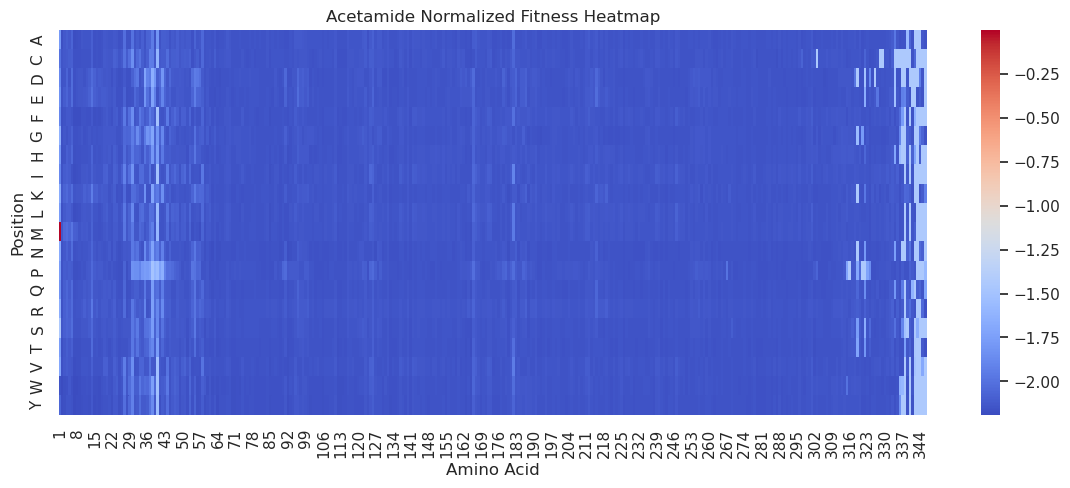

In [27]:

df_pivot = preds.pivot(columns='position', index='amino_acid', values='mean')

# Create  heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(df_pivot, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Acetamide Normalized Fitness Heatmap')
plt.xlabel('Amino Acid')
plt.ylabel('Position')
plt.show()



## Sequence design

We can set up a design job using our trained model as a criteria. To do this we will also need to supply a mutation map that defines positions and residues that we want mutated. 

We have some helper functions that can be used to initialize your design mutation dict:

In [28]:
from openprotein.api.design import DesignConstraint

parent_sequence = dataset.sequence[0]
print(parent_sequence)

# init the design constraints 
design = DesignConstraint(parent_sequence)

# we'll then update the constraints to allow G,I,L mutations at pos 2, 3
design.allow([2, 3], ["G", "I", "L"])

# get the mapping
mutations = design.as_dict()

# Pretty print the first 6 positions
for i, (key, value) in enumerate(mutations.items()):
    if i < 6:
        print(f"Position {key} - Allowed residues: {' '.join(value)}")
    else:
        break
    

WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA
Position 1 - Allowed residues: W
Position 2 - Allowed residues: R G I L
Position 3 - Allowed residues: H G I L
Position 4 - Allowed residues: G
Position 5 - Allowed residues: D
Position 6 - Allowed residues: I


In [29]:
model_id = train.list_models()[0]['model_id']

In [30]:
from openprotein.api.design import DesignJobCreate, ModelCriterion, NMutationCriterion, Criterion
design_data = DesignJobCreate(
    assay_id=assay.id,
    criteria=[
        [
            ModelCriterion(
                criterion_type='model',
                model_id=model_id,
                measurement_name="acetamide_normalized_fitness",
                criterion=Criterion(target=-0.5, weight=1.0, direction="<")
            ),
        ],
        [NMutationCriterion(criterion_type="n_mutations", )]
    ],
    num_steps=3,
    allowed_tokens=mutations
)


json.loads(design_data.json())

# create the design job
design_job = session.design.create_design_job(design_data)

design_id = design_job.id
design_job



DesignJob(status=<JobStatus.PENDING: 'PENDING'>, job_id='fc63af1f-7e97-4b2d-b0b0-b1a54841398e', job_type=<JobType.workflow_design: '/workflow/design'>, created_date=datetime.datetime(2024, 4, 9, 2, 8, 57, 707464), start_date=None, end_date=None, prerequisite_job_id=None, progress_message=None, progress_counter=None, num_records=None, sequence_length=None)

In [31]:

results = design_job.wait()

In [32]:
results[0:2]# limit results for readability

[{'step': 0,
  'sample_index': 0,
  'sequence': 'WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA',
  'scores': [[{'score': 0.0,
     'metadata': {'y_mu': -2.1514909267425537,
      'y_var': 0.00010183453559875488}}],
   [{'score': 346.0, 'metadata': {'y_mu': None, 'y_var': None}}]]},
 {'step': 0,
  'sample_index': 1,
  'sequence': 'WRGGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA',
  'scores': [[{'sc

We can also get a specific step from the design process:

In [33]:
design_job.get(step=1)[0:2] # limit results for readability

[{'step': 1,
  'sample_index': 16,
  'sequence': 'WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA',
  'scores': [[{'score': 0.0,
     'metadata': {'y_mu': -2.1514909267425537,
      'y_var': 0.00010183453559875488}}],
   [{'score': 346.0, 'metadata': {'y_mu': None, 'y_var': None}}]]},
 {'step': 1,
  'sample_index': 17,
  'sequence': 'WRGGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA',
  'scores': [[{'

## Resume workflows 

Lastly, it's possible to resume from where you left off with the job id:

In [35]:
train = session.load_job(train_id)
train

Job(status=<JobStatus.SUCCESS: 'SUCCESS'>, job_id='150860c1-d8b0-4804-8914-28409bbcc0fe', job_type='/workflow/train', created_date=datetime.datetime(2024, 4, 9, 2, 4, 38, 309629), start_date=datetime.datetime(2024, 4, 9, 2, 5, 39, 87864), end_date=datetime.datetime(2024, 4, 9, 2, 5, 53, 926863), prerequisite_job_id='ccad1469-5843-414c-90cd-2f93149df1f3', progress_message=None, progress_counter=None, num_records=None, sequence_length=None)

This reloaded job can be used as above for predict or design tasks, and those can also be reloaded!

In [36]:
pjob = session.load_job(pjob_id)
pjob

PredictJob(status=<JobStatus.SUCCESS: 'SUCCESS'>, job_id='44658be8-90e4-4fda-9adf-250332de6754', job_type=<JobType.workflow_predict: '/workflow/predict'>, created_date=datetime.datetime(2024, 4, 9, 2, 6, 5, 583324), start_date=datetime.datetime(2024, 4, 9, 2, 6, 13, 707885), end_date=datetime.datetime(2024, 4, 9, 2, 6, 24, 363649), prerequisite_job_id='150860c1-d8b0-4804-8914-28409bbcc0fe', progress_message=None, progress_counter=None, num_records=None, sequence_length=None, result=None)